<a href="https://colab.research.google.com/github/eispoohw/CS493-Math-Methods-in-ML/blob/main/lab%203.1-3.4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Линейная регрессия


Линейные методы предполагают, что между признаками объекта и целевой переменной существует линейная зависимость, то есть:
$$ \hat{y} = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b,$$
где $\hat{y}$ - целевая переменная (что мы хотим предсказать), $x_i$ - i-ый признак объекта $x$, $w_i$ - вес $i$-го признака, $b$ - bias (смещение, свободный член).

В задаче линейной регрессии $\hat{y}$ - это действительное число.

Часто для упрощения записи вводят дополнительный фиктивный признак $x_0$, который всегда равен 1, тогда bias - вес этого признака. В этом случае формула может быть записана как скалярное произведение:
$$ \hat{y} = <w, x> $$

В матричной форме формулу можно переписать следующим образом:
$$ \hat{y} = Xw,$$
$\hat{y}$ - вектор значений целевой переменной размера $n$, $X$ - матрица значений признаков объектов размера $n \times k$, w - вектор весов размера $k$. То есть в наших данных имеется $n$ объектов, каждый их которых описан $k$ признаками.

Таким образом, в матричной форме модель задаётся следующим образом:
$$ y = Xw + \epsilon$$ 

Важно отметить, что параметрами этой модели являются веса $w$. Когда говорят об обучении какого-либо алгоритма машинного обучения, как правило, имеют в виду настройку весов, т.е. параметров модели.  

На практике $\hat{y} $ может отличается от реальных значений, которые принимает целевая переменная $y$. Разницу между реальным значением и предсказанным, обозначим как $\epsilon$ - вектор значений случайной переменной, соответствующая случайной, непрогнозируемой ошибке модели. Ограничения, которые накладываются на эту модель:
* математическое ожидание случайных ошибок $\epsilon$ равно нулю,
* дисперсия случайных ошибок одинакова и конечна,
* случайные ошибки не скоррелированы.

Один из способов вычислить значения параметров модели, давно знаком - это наименьших квадратов, который минимизирует среднеквадратичную ошибку между реальным значением зависимой переменной и прогнозом, выданным моделью. Решение по методу наименьших квадратов дает:
$$ w = (X^TX)^{-1}X^TY $$

Загрузим необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import typing as tp
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Оценка результатов

Чтобы оценить качество работы алгоритма нам необходимо применяют разные метрики. Наиболее частые метрики средневадратичная и средняя абсолютная ошибки. Вычислим эти метрики на обучающей и на тестовой выборках. 

 * *mean_absolute_error* - средняя абсолютная ошибка $|y_i - \hat{y}_i|$
 * *mean_squared_error* - средняя квадратичная ошибка $(y_i - \hat{y}_i)^2$

## Задание 3.1

Пример 1. Сгенерируем искусственные данные. Сначала поработаем с простейшим одномерным случаем, когда у нас значение $y$ будет зависеть только от одного значения $x$.




In [2]:
def generate_data(n_points=20):
    """
        Принимает на вход n_points точек 
        Возвращает данные для обучения и теста
    """
    X = np.linspace(-5, 5, n_points)
    y = 10 * X - 7

    X_train = X[0::2].reshape(-1, 1)
    y_train = y[0::2] + np.random.randn(int(n_points/2)) * 10

    X_test = X[1::2].reshape(-1, 1)
    y_test = y[1::2] + np.random.randn(int(n_points/2)) * 10

    print(f'Generated {len(X_train)} train samples and {len(X_test)} test samples')
    return X, X_train, y_train, X_test, y_test

In [3]:
X, X_train, y_train, X_test, y_test = generate_data(100)

Generated 50 train samples and 50 test samples


Задание:
1. Реализуйте настройку w и b с помощью рассмотренного выше метода наименьших квадратов.
2. Найдите значения метрик MSE и MAE. Сравните с результатами из sklearn

### Решение

In [4]:
class LeastSquares:
    def __init__(self):
        self._w = None # np.array of weights
        self._b = None # bias

    def fit(self, X, y):
        """ 
            calculates weights and bias using the matrix method 
        """
        X_b = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1) # add x_0 column for bias to the end
        w = np.linalg.pinv(X_b)@y # (X.T * X)^(-1) * X.T * Y
        self._w = w[:-1]
        self._b = w[-1]
        return self._w, self._b

    def predict(self, X): return np.dot(X, self._w) + self._b

    def MAE(self, X, y): return np.average(np.abs(y - self.predict(X)))

    def MSE(self, X, y): return np.average(np.power(y - self.predict(X), 2))

    def get_params(self, X_train, y_train, X_test=None, y_test=None, add_x=False):
        """ 
            fitting model and returning dictionary with parameters:
                label, weights, bias, MAE (train data), MSE (train data)
                optional: MAE (test data), MSE (test data), X, Y
        """
        self.fit(X_train, y_train)
        res = {
            'label': 'least-squares',
            'weights': self._w,
            'bias': self._b,
        }
        if X_test is None:
            res['MAE'] = self.MAE(X_train, y_train)
            res['MSE'] = self.MSE(X_train, y_train)
        else: 
            res['MAE train'] = self.MAE(X_train, y_train)
            res['MAE test'] = self.MAE(X_train, y_train)
            res['MSE train'] = self.MSE(X_train, y_train)
            res['MSE test'] = self.MSE(X_test, y_test)
        if add_x:
            res['x'] = X_train[:, 0]
            res['y'] = self.predict(X_train)
        return res



def plotting_results(X, values, params, title='Results', initial_function=None, size=(20,10)):
    """
        Plotting data from custom dataframe
            points, initial function, trained function
    """
    plt.figure(figsize=size)
    plt.scatter(X, values, color='grey')
    if initial_function is not None:
        plt.plot(X, initial_function, label='initial function')
    for i, row in params.iterrows():
        plt.plot(row['x'], row['y'], label=row['label'])
    plt.title(title)
    plt.legend()
    plt.show()

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# create models
reg = LinearRegression().fit(X_train, y_train)
ls = LeastSquares()

# create and fill dataframe
params_1 = pd.DataFrame()
params_1 = params_1.append(ls.get_params(X_train, y_train, X_test, y_test, add_x=True), ignore_index=True)
params_1 = params_1.append({
    'label': 'sklearn LinearRegression',
    'x': X_train.flatten(),
    'y': reg.predict(X_train),
    'weights': reg.coef_,
    'bias': reg.intercept_,
    'MAE train': mean_absolute_error(y_train, reg.predict(X_train)),
    'MAE test': mean_absolute_error(y_test, reg.predict(X_test)),
    'MSE train': mean_squared_error(y_train, reg.predict(X_train)),
    'MSE test': mean_squared_error(y_test, reg.predict(X_test))
}, ignore_index=True)

params_1.set_index('label').drop(['x', 'y'], axis=1)

,weights,bias,MAE train,MAE test,MSE train,MSE test
label,,,,,,
least-squares,[9.613662349612898],-7.536373,9.123108,9.123108,119.992078,104.672661
sklearn LinearRegression,[9.613662349612898],-7.536373,9.123108,8.393617,119.992078,104.672661


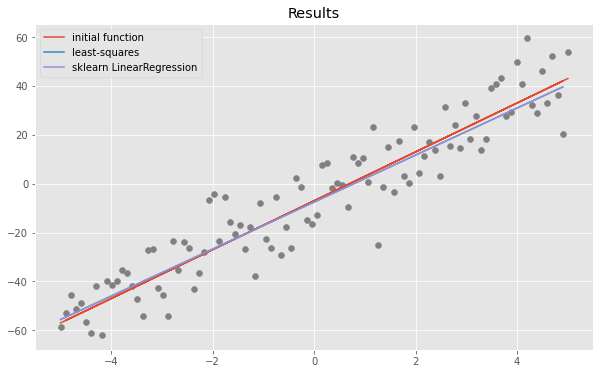

In [6]:
plotting_results(np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test)), params_1, initial_function=np.concatenate((X_train, X_test))*10-7, size=(10, 6))

## Задание 3.2

Пример 2. Не всегда в задаче регрессии в качестве решения выступает прямая, как в предыдущем случае. Рассмотрим ещё один пример, в котором у объектов всё ещё один признак. Но теперь мы будм брать случайную точку на синусоиде и добавлять к ней шум — таким образом получим целевую переменную, признаком в этом случае будет координата $x$.

In [7]:
def generate_wave_set(n_support=1000, n_train=25, std=0.3):
    data = {}
    # выберем некоторое количество точек из промежутка от 0 до 2*pi
    data['support'] = np.linspace(0, 2*np.pi, num=n_support)
    # для каждой посчитаем значение sin(x) + 1
    # это будет ground truth
    data['values'] = np.sin(data['support']) + 1
    # из support посемплируем некоторое количество точек с возвратом, это будут признаки
    data['x_train'] = np.sort(np.random.choice(data['support'], size=n_train, replace=True))
    # опять посчитаем sin(x) + 1 и добавим шум, получим целевую переменную
    data['y_train'] = np.sin(data['x_train']) + 1 + np.random.normal(0, std, size=data['x_train'].shape[0])
    return data

data = generate_wave_set(1000, 250)

Задание:
1. Попробуйте реализовать настройку w и b с помощью рассмотренного выше метода наименьших квадратов.
2. Найдите значения метрик MSE и MAE

### Решение

In [8]:
# prepare data
X_sin_train = np.array([data['x_train']]).T

# create a model, fit it and get the parameters
ls2 = LeastSquares()
task2_params = ls2.get_params(X_sin_train, data['y_train'])

pd.DataFrame(task2_params).set_index('label')

,weights,bias,MAE,MSE
label,,,,
least-squares,-0.302414,1.947269,0.430233,0.273757


Конечно, такое решение нас вряд ли может устроить. Нужно применить полинимиальную регрессию. Идея здесь такая. Каждый признак в исходную формулу может входить не только в первой степени, но и во второй, в третьей и так далее. То есть для случая, когда у нас только один признак:
$$ \hat{y} = w_1 x_1 + w_2 x_1^2 + ... + w_k x_1^k + b,$$ 

## Задание 3.3

1. Реализуйте полиномиальную регрессию. Сделайте визуализацию для полиномов разных степеней. 
2. Полином какой степени подходит больше других? Почему?

### МНК

In [9]:
def get_x_power(X, power):
    """
        polynomises the feature
    """
    X = X.T
    for _ in range(power - 1):
        X = np.vstack((X, X[0] * X[-1])) 
    return X.T

In [10]:
# SETTINGS: desired degrees of polynomials
POWERS = [i for i in range(1, 11, 1)]


polynomialResults = pd.DataFrame()

for p in POWERS:
    params = ls.get_params(get_x_power(X_sin_train, p), data['y_train'], add_x=True)
    params['degree'] = p # add column with power value
    params['label'] = f"P_{p}" # model name -> P_{power}
    polynomialResults = polynomialResults.append(params, ignore_index=True)

polynomialResults = polynomialResults
polynomialResults.set_index(['degree']).drop(['x', 'y'], axis=1).sort_values(by=['MAE', 'MSE'])

,label,weights,bias,MAE,MSE
degree,,,,,
10.0,P_10,"[5.585975645055964, -17.792950449495585, 27.85...",0.820932,0.221574,0.078406
7.0,P_7,"[1.4182969889688763, -1.6670717628169875, 1.65...",1.036274,0.221750,0.080788
9.0,P_9,"[4.001483333438599, -10.47966220881641, 13.995...",0.880419,0.222268,0.078936
8.0,P_8,"[2.6942723346991606, -5.503588446407241, 6.322...",0.945289,0.222364,0.079547
6.0,P_6,"[0.2408097894316047, 1.0009321492455403, -0.78...",1.159510,0.224559,0.082573
5.0,P_5,"[0.5496866078324858, 0.4980920006898914, -0.45...",1.112293,0.224606,0.082789
4.0,P_4,"[1.5936604879460996, -0.6641017524226054, 0.04...",0.881949,0.230885,0.087596
3.0,P_3,"[1.885300695026432, -0.874059729816459, 0.0930...",0.788164,0.233434,0.088549
2.0,P_2,"[-0.23018156796979175, -0.011744912140625789]",1.875627,0.427551,0.272594


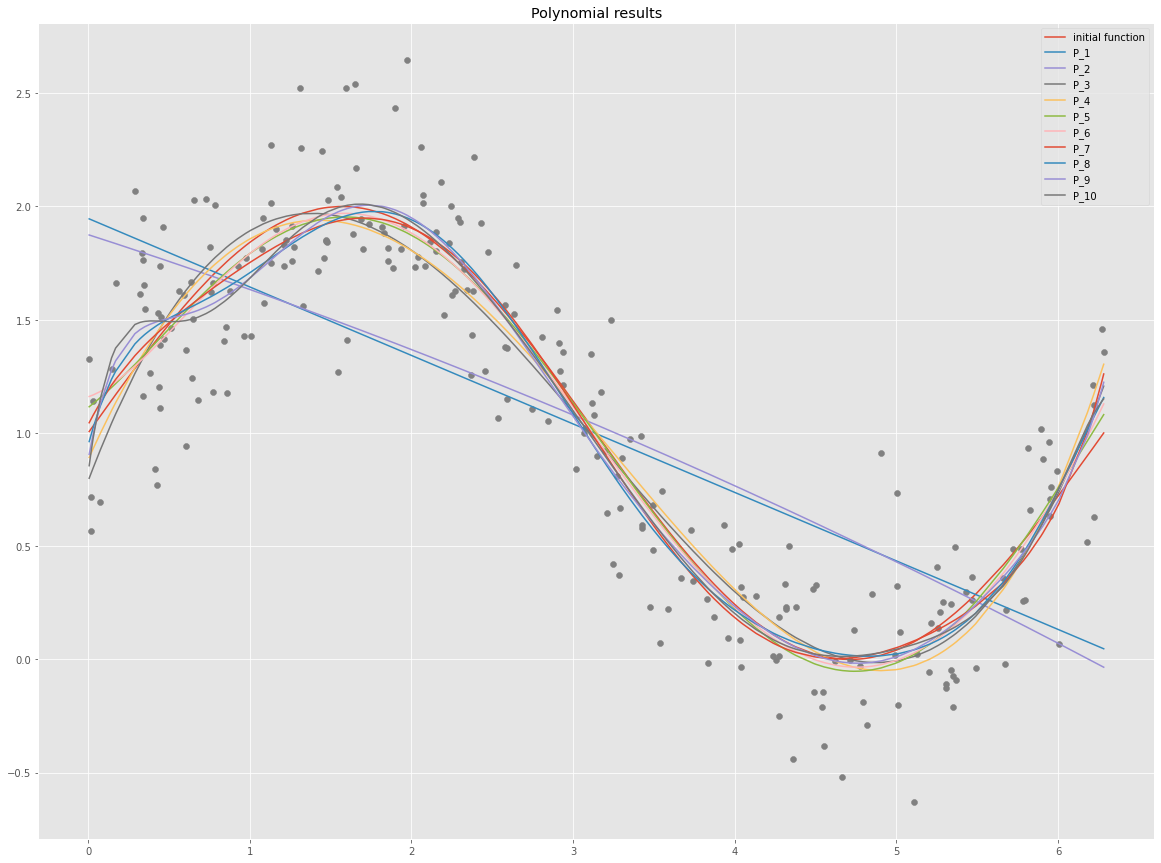

In [11]:
plotting_results(data['x_train'], data['y_train'], polynomialResults, title='Polynomial results', initial_function=np.sin(data['x_train']) + 1, size=(20,15))

### sklearn

In [12]:
from sklearn.preprocessing import PolynomialFeatures


polynomialResultsSklearn = pd.DataFrame(None, columns=['degree', 'weights', 'bias'])
exact_match = 0

for i, p in enumerate(POWERS):
    xpoly = PolynomialFeatures(degree=p).fit_transform(X_sin_train)
    reg.fit(xpoly, data['y_train'])
    polynomialResultsSklearn = polynomialResultsSklearn.append({
        'label': f"P_{p}",
        'degree': p,
        'weights': reg.coef_,
        'bias': reg.intercept_,
        'x': data['x_train'],
        'y': reg.predict(xpoly),
        'MAE': mean_absolute_error(data['y_train'], reg.predict(xpoly)),
        'MSE': mean_squared_error(data['y_train'], reg.predict(xpoly)),
    }, ignore_index=True)
    if reg.intercept_ == polynomialResults['bias'][i] and  reg.coef_ == polynomialResults['weights'][i] :
       exact_match += 1

polynomialResultsSklearn.set_index(['degree']).drop(['x', 'y'], axis=1).sort_values(by=['MAE', 'MSE'])

,weights,bias,MAE,MSE,label
degree,,,,,
10,"[0.0, 5.585975547594826, -17.79295021708083, 2...",0.820932,0.221574,0.078406,P_10
7,"[0.0, 1.4182969890349404, -1.6670717629351017,...",1.036274,0.221750,0.080788,P_7
9,"[0.0, 4.001483313557663, -10.479662176668695, ...",0.880419,0.222268,0.078936,P_9
8,"[0.0, 2.694272335742974, -5.503588448968333, 6...",0.945289,0.222364,0.079547,P_8
6,"[0.0, 0.24080978942956038, 1.0009321492449543,...",1.159510,0.224559,0.082573,P_6
5,"[0.0, 0.549686607832653, 0.4980920006896964, -...",1.112293,0.224606,0.082789,P_5
4,"[0.0, 1.5936604879461398, -0.6641017524226607,...",0.881949,0.230885,0.087596,P_4
3,"[0.0, 1.8853006950264402, -0.8740597298164597,...",0.788164,0.233434,0.088549,P_3
2,"[0.0, -0.23018156796979222, -0.011744912140625...",1.875627,0.427551,0.272594,P_2


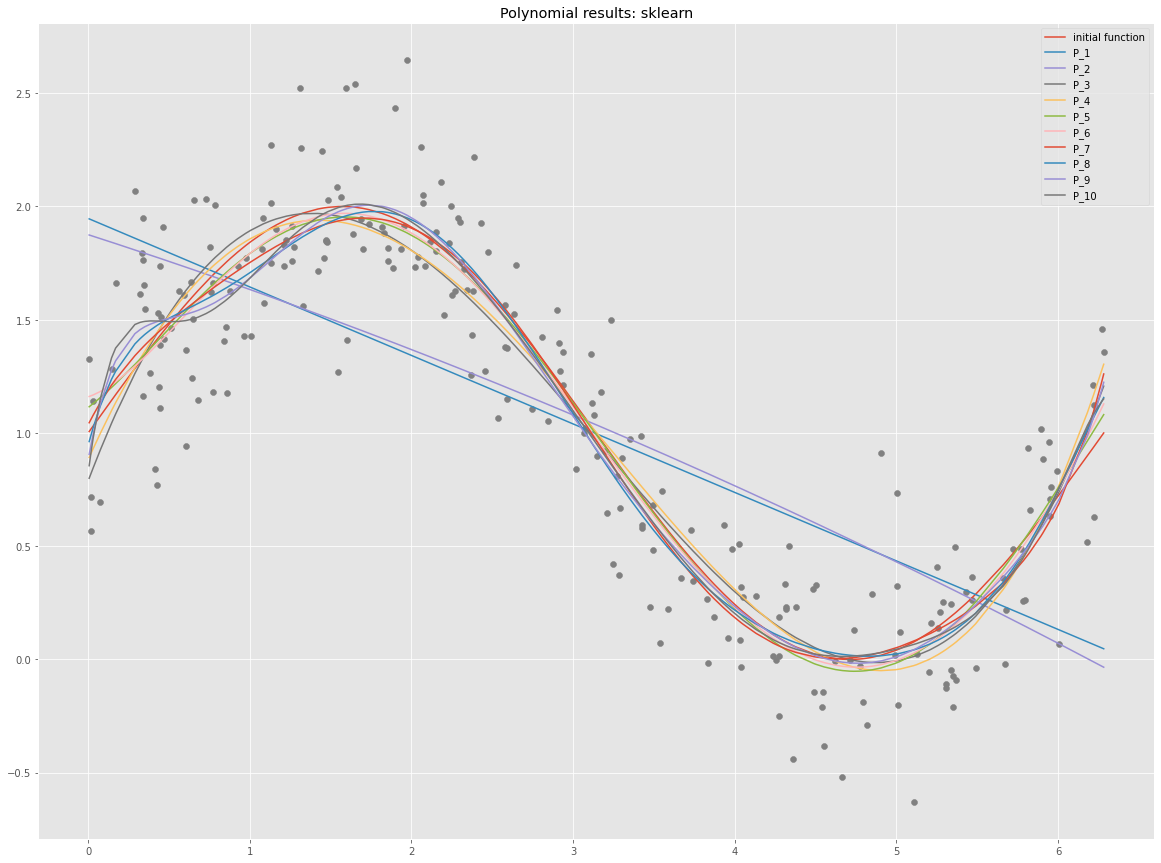

In [13]:
plotting_results(data['x_train'], data['y_train'], polynomialResultsSklearn, title='Polynomial results: sklearn', initial_function=np.sin(data['x_train']) + 1, size=(20,15))

### Полином какой степени подходит больше других

В данном случае
- на графиках функций видно, что полиномы, **начиная с 3 степени**, подходят, а при дотяжении приблизительно **7 степени** излишне подстраиваются под тренировочные данные и обобщающая способность модели теряется.
- при расмотрении MSE и MAE, заметно, что минимальные значения получаются при использовании полиномов 7 - 9 степеней, но значения для 3 - 6 степеней не сильно больше.

**Вывод**: на мой взгляд, лучше всего использовать **полином 5 степени** (судя по графикам на концах области определения).

*Однако, так будет только на рассматриваемом отрезке. Если же речь идет о первоначальной синусоиде в области действительных чисел, то очевидно, что полученные выше модели - не то, что нужно:*

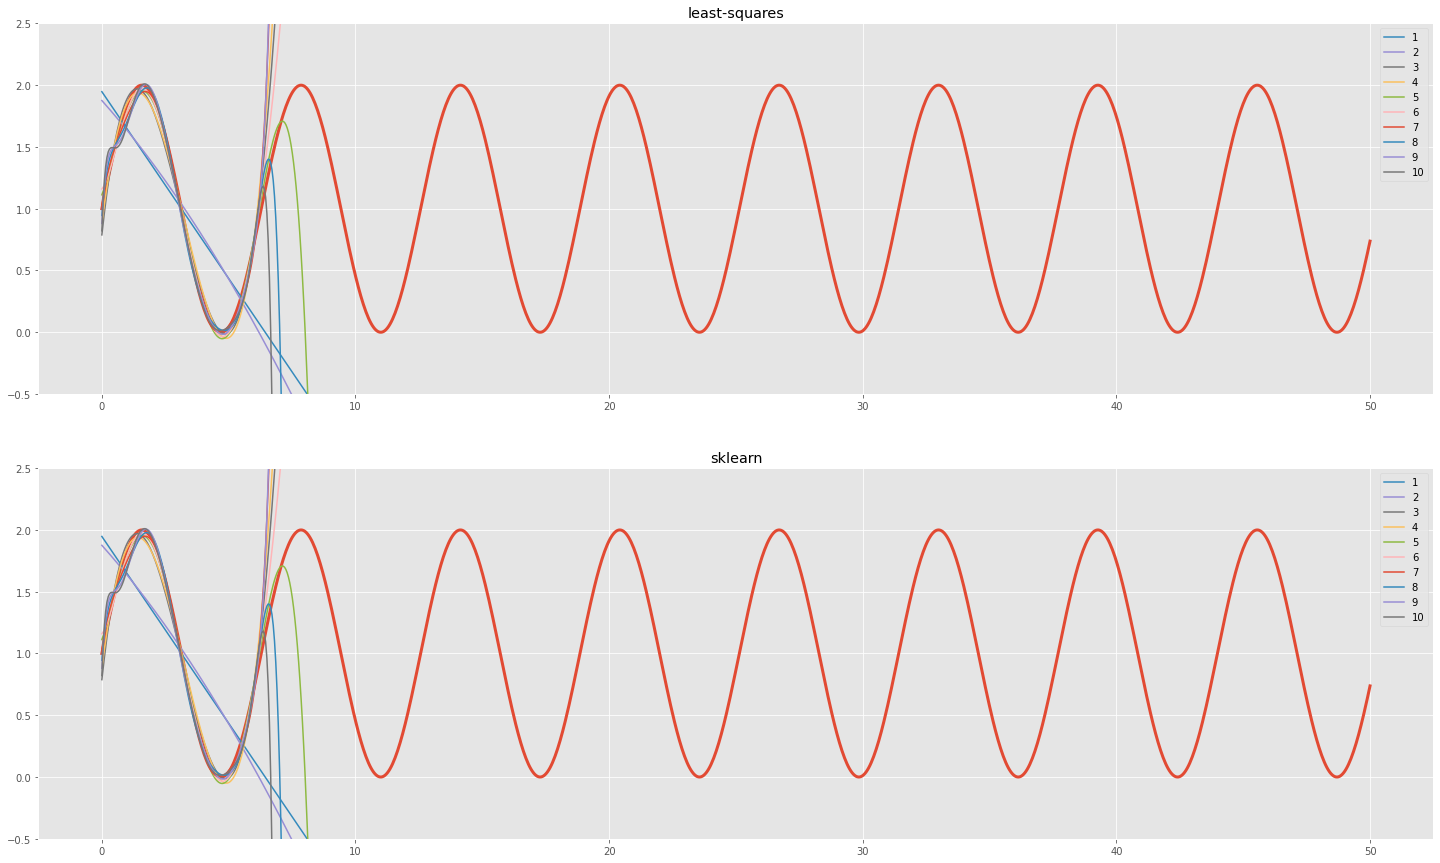

In [14]:
Xes = np.linspace(0, 50, 1000)

plt.figure(figsize=(25, 15))

lsG = plt.subplot(211)
sklearnG = plt.subplot(212, sharex=lsG)

lsG.set_ylim(-0.5, 2.5)
sklearnG.set_ylim(-0.5, 2.5)

lsG.plot(Xes, np.sin(Xes) + 1, linewidth = 3)
sklearnG.plot(Xes, np.sin(Xes) + 1, linewidth = 3)

lsG.set_title('least-squares')
sklearnG.set_title('sklearn')

for _, row in polynomialResultsSklearn.iterrows():
    sklearnG.plot(Xes, np.dot(PolynomialFeatures(degree=row['degree']).fit_transform(Xes.reshape(-1, 1)), row['weights']) + row['bias'], label=f"{int(row['degree'])}")
for _, row in polynomialResults.iterrows():
    lsG.plot(Xes, np.dot(get_x_power(Xes.reshape(-1, 1), int(row['degree'])), row['weights']) + row['bias'], label=f"{int(row['degree'])}")

lsG.legend(loc="upper right")
sklearnG.legend(loc="upper right")

# Реальный датасет

Возьмём реальный набор данных Boston из sklearn.datasets. Этот датасет описывает средние цены на недвижимость в районах Бостона в тысячах долларов.

Примеры признаков объектов недвижимости: количество преступлений на душу населения, процент старых домов в районе, количество учеников на одного учителя и т.д. Обратите внимание на то, что данные уже оцифрованы там, где изначально признаки были качественными.

Загрузим датасет, выведем информацию

In [15]:
from sklearn.datasets import load_boston
house_data = load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [16]:
X = pd.DataFrame(house_data['data'], columns=house_data['feature_names'])
y = house_data['target']
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


## Задание 3.4

1. оставьте в наборе данных только 7 наиболее значимых признаков
2. настройте параметры линейной регрессии и сравните метрики качества (MSE и MAE) для полного датасета и усечённого

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

boston_results = pd.DataFrame(columns=['sample', 'MAE train', 'MAE test', 'MSE test', 'MSE train'])
boston_results = boston_results.append({
    'sample': 'full',
    'MSE train': mean_squared_error(y_train, y_train_prediction),
    'MSE test': mean_squared_error(y_test, y_test_prediction),
    'MAE train': mean_absolute_error(y_train, y_train_prediction),
    'MAE test': mean_absolute_error(y_test, y_test_prediction)
}, ignore_index=True)


weak = pd.DataFrame(np.abs(model.coef_.reshape(1, -1)), columns=house_data['feature_names']).T.sort_values(by=0).head(len(X.columns) - 7).index

X7 = X.drop(weak, axis=1)
X7

,NOX,RM,DIS,RAD,TAX,PTRATIO,LSTAT
0,0.538,6.575,4.0900,1.0,296.0,15.3,4.98
1,0.469,6.421,4.9671,2.0,242.0,17.8,9.14
2,0.469,7.185,4.9671,2.0,242.0,17.8,4.03
3,0.458,6.998,6.0622,3.0,222.0,18.7,2.94
4,0.458,7.147,6.0622,3.0,222.0,18.7,5.33
...,...,...,...,...,...,...,...
501,0.573,6.593,2.4786,1.0,273.0,21.0,9.67
502,0.573,6.120,2.2875,1.0,273.0,21.0,9.08
503,0.573,6.976,2.1675,1.0,273.0,21.0,5.64
504,0.573,6.794,2.3889,1.0,273.0,21.0,6.48


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X7, y, train_size=0.7)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

boston_results = boston_results.append({
    'sample': '7 strongest',
    'MSE train': mean_squared_error(y_train, y_train_prediction),
    'MSE test': mean_squared_error(y_test, y_test_prediction),
    'MAE train': mean_absolute_error(y_train, y_train_prediction),
    'MAE test': mean_absolute_error(y_test, y_test_prediction)
}, ignore_index=True)

boston_results.set_index('sample')

,MAE train,MAE test,MSE test,MSE train
sample,,,,
full,2.966543,3.759221,40.422733,16.330074
7 strongest,3.559914,3.335593,23.245916,24.442799
